1. Density
2. Capacity
3. Number of stations nearby
    - Stations graph

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import collections as col
import patchwork

response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json")
incidentes = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones_barrios.json")
dist_est_barrios = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones.json")
dist_est = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json")
barrios = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/estaciones.json")
estaciones = json.loads(response.text)

In [2]:
dic_density = {}
for b in barrios:
    dic_density[b['nta']] = round( (b['population'] / b['shape_area'])*100 , 5)

dic_incid = {}
for i in incidentes:
    barri = i['nta'] # barrio del incidente
    if barri not in dic_incid: # si el barrio no se guardó aún
        dic_incid[barri] = {} # dic dentro de cada barrio
        # incidentes de noche y de día con dic de conteo de incidentes
        dic_incid[barri]['noche'] = {'num_incid': 0}
        dic_incid[barri]['dia'] = {'num_incid': 0}
    turno = 'noche'
    if i['is_first_shift'] == False: # si el incidente es de día
        turno = 'dia'

    dic_incid[barri][turno]['num_incid'] += 1 # aumentamos contador

    incid_pos = dic_incid[barri][turno]['num_incid']
    # cogemos valor de incidente y lo usamos para crear lista de tipos de vehículos
    # cada posición de la lista es un tipo de vehículo.
    dic_incid[barri][turno][f'incidente_{incid_pos}'] = [0,0,0,0,0]

    units = i['units'] # guardamos tipos de vehiculo del incidente
    for u in set(units): # set para sacar valores únicos
        # guardamos valores de vaca tipo de vehículo por incidente
        if u == 'engine':
            dic_incid[barri][turno][f'incidente_{incid_pos}'][0] += units.count(u)
        elif u == 'ladder':
            dic_incid[barri][turno][f'incidente_{incid_pos}'][1] += units.count(u)
        elif u == 'rescue':
            dic_incid[barri][turno][f'incidente_{incid_pos}'][2] += units.count(u)
        elif u == 'squad':
            dic_incid[barri][turno][f'incidente_{incid_pos}'][3] += units.count(u)
        elif u == 'hazardous':
            dic_incid[barri][turno][f'incidente_{incid_pos}'][4] += units.count(u)

dic_ests = {}
barrios_cerca, densidades, incids_noche, incids_dia = [],[],[],[]
vhs_noche, vhs_dia, capacidades, estaciones_cerca = [],[],[],[]
nom_estaciones = []

for i in estaciones:
    ### NOMBRE DE LA ESTACIÓN
    dir = i['address']
    dic_ests[dir] = {}

    nom_estaciones.append(dir)

    ### BARRIOS CERCANOS (<= 780 segs)
    dic_ests[dir]['barrios_cercanos'] = {}
    for b,d in dist_est_barrios[dir].items():
        if d <= 780: # menos de esta dist no en algunas no entran barrios.
            dic_ests[dir]['barrios_cercanos'][b] = [d]

    barrios_cerca.append(len(dic_ests[dir]['barrios_cercanos']))

    ### BARRIO DE LA ESTACIÓN CON NOMBRE, DISTANCIA Y DENSIDAD
    dist, barrio = min((v[0],k) for k,v in dic_ests[dir]['barrios_cercanos'].items())
    dic_ests[dir]['barrio'] = [barrio, dist, dic_density[barrio]]

    densidades.append(dic_density[barrio])

    ### INCIDENTES EN BARRIOS CERCANOS
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
        if b in dic_incid.keys():
            d.append(dic_incid[b])
        else:
            d.append({})

    ### INCIDENTES MÁXIMOS DE DÍA Y DE NOCHE EN UN BARRIO
    incid_mean_noche, incid_mean_dia = [],[]
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
    if d[1] != {}:
        if d[1]['noche'] != {}:
            incid_mean_noche.append((d[1]['noche']['num_incid'], b))
        else:
              incid_mean_noche.append((0, b))
        if d[1]['dia'] != {}:
            incid_mean_dia.append((d[1]['dia']['num_incid'], b))
        else:
            incid_mean_dia.append((0, b))
    else:
        incid_mean_noche.append((0, b))
        incid_mean_dia.append((0, b))

    incid_mean_noche = int(np.mean([x[0] for x in incid_mean_noche]))
    incid_mean_dia = int(np.mean([x[0] for x in incid_mean_dia]))

    dic_ests[dir]['incidentes_max'] = {'noche': incid_mean_noche,
                                       'dia': incid_mean_dia }

    incids_noche.append(incid_mean_noche)
    incids_dia.append(incid_mean_dia)

    ### TIPOS DE VEHÍCULOS EN BASE A INCIDENTES
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
        if d[1] != {}:
            mean_vh_noche = np.mean(np.array([ v if (k != 'num_incid' and d[1]['noche'] is not None) else [0,0,0,0,0]
                                                      for k,v in d[1]['noche'].items() ]), axis=0)
            mean_vh_dia = np.mean(np.array([ v if (k != 'num_incid' and d[1]['dia'] is not None) else [0,0,0,0,0]
                                                      for k,v in d[1]['dia'].items() ]), axis=0)
        else:
            continue
        dic_ests[dir]['media_tipo_vhs'] = {
              'noche': list(mean_vh_noche),
              'dia': list(mean_vh_dia)
          }

    vhs_noche.append(list(mean_vh_noche))
    vhs_dia.append(list(mean_vh_dia))

    ### CAPACIDAD DE LA ESTACIÓN
    dic_ests[dir]['capacidad'] = i['capacity']

    capacidades.append(dic_ests[dir]['capacidad'])

    ### ESTACIONES CERCANAS A ESA ESTACIÓN (<= 600 seg)
    dic_ests[dir]['estaciones_cercanas'] = []
    for e,d in dist_est[dir].items():
        if d <= 700:
            dic_ests[dir]['estaciones_cercanas'].append((e,d))

    estaciones_cerca.append(len(dic_ests[dir]['estaciones_cercanas']))

# 1. Density

In [3]:
dic_density = {} # dictionary of pre-calculated neighbourhood densities
for b in barrios:
    dic_density[b['nta']] = round( (b['population'] / b['shape_area'])*100 , 5)
populations = [b["population"] for b in barrios]
areas = [b["shape_area"] for b in barrios]

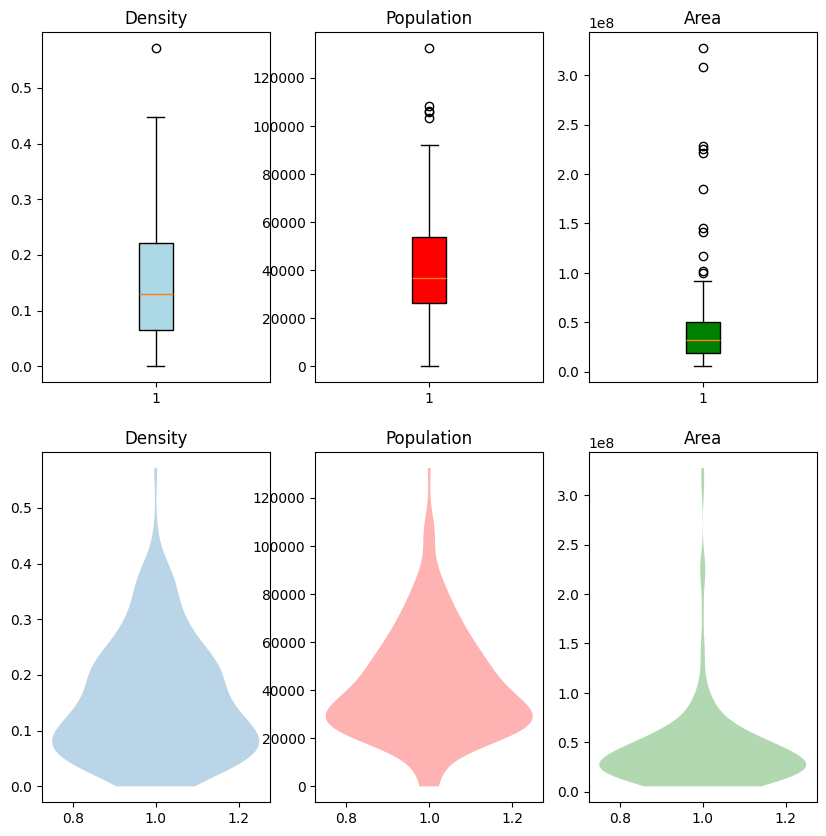

In [4]:
##############################################
### Box plots density, area, population ###
##############################################

plt.figure(figsize=((10,10)))
plt.subplot(2,3,1)
plt.title("Density")
b = plt.boxplot(dic_density.values(), patch_artist = True, boxprops = dict(facecolor = "lightblue"))

plt.subplot(2,3,2)
plt.title("Population")
plt.boxplot(populations, patch_artist = True, boxprops = dict(facecolor = "red"))

plt.subplot(2,3,3)
plt.title("Area")
plt.boxplot(areas, patch_artist = True, boxprops = dict(facecolor = "green"))

##############################################
### Violin plots density, area, population ###
##############################################

plt.subplot(2,3,4)
plt.title("Density")
plt.violinplot(dic_density.values(),showmeans=False, showmedians=False, showextrema=False)

plt.subplot(2,3,5)
plt.title("Population")
v2 = plt.violinplot(populations,showmeans=False, showmedians=False, showextrema=False)
for pc in v2["bodies"]:
    pc.set_facecolor("red")

plt.subplot(2,3,6)
plt.title("Area")
v3 = plt.violinplot(areas,showmeans=False, showmedians=False, showextrema=False)
for pc in v3["bodies"]:
    pc.set_facecolor("green")
plt.show()

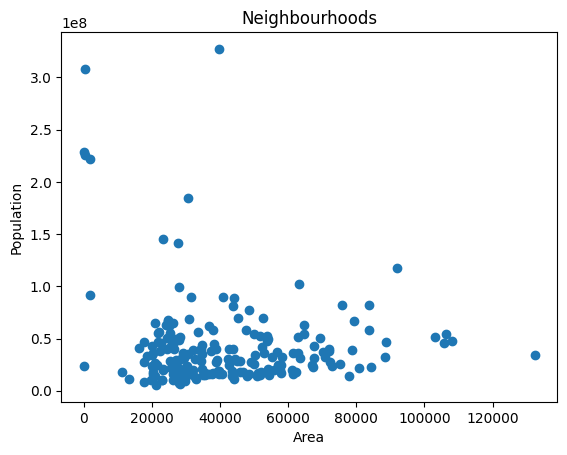

In [5]:
##############################################
### Scatter plot area x population ###
##############################################
plt.figure()
plt.title("Neighbourhoods")
plt.xlabel("Area")
plt.ylabel("Population")
plt.scatter(populations, areas)
plt.show()

# 2. Capacity

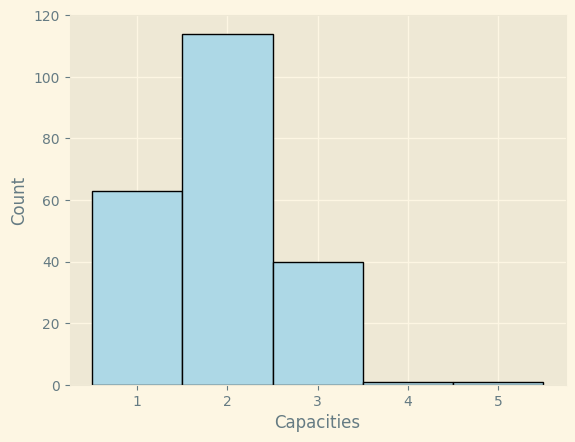

In [17]:
##############################################
### histogram of Capacities ###
##############################################
capacidades = [c["capacity"] for c in estaciones]
plt.figure()
plt.style.use('seaborn-v0_8-muted')
plt.hist(capacidades, edgecolor="black", bins=np.arange(1,7)-0.5, color="lightblue")
plt.xticks([1,2,3,4,5])
plt.yticks([0,20,40,60,80, 100, 120])
plt.xlabel("Capacities")
plt.ylabel("Count")
plt.show()

# 3. Number of stations nearby

## Stations Graph

In [32]:
G = nx.Graph() # Build a graph
G.add_nodes_from(dic_ests.keys())
aristas = []
for i,v in dic_ests.items():
    for j,w in v["estaciones_cercanas"]:
        aristas.append((i,j,w))
G.add_weighted_edges_from(aristas)

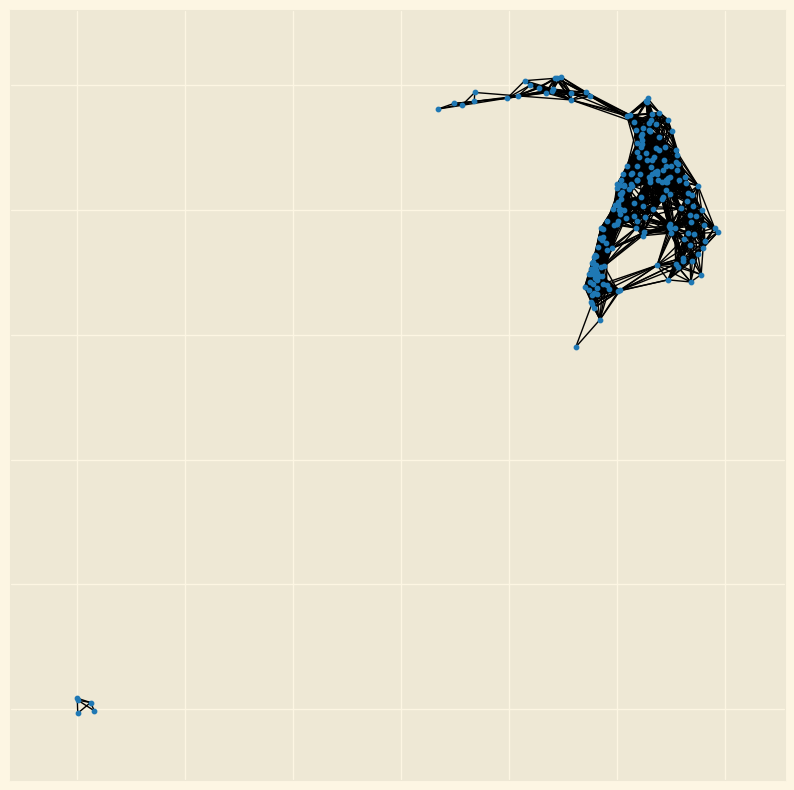

In [33]:
##############################################
### Graph nearby stations with networkx ###
##############################################
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(G, with_labels=False, ax=ax, node_size=10)

In [34]:
##############################################
### Graph of nearby stations on map ###
##############################################
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
json_response = json.loads(response.text)

dic_est_coords = {}
for i in json_response["features"]:
    dic_est_coords[i["properties"]["FacilityAddress"]] = i["geometry"]["coordinates"]

map = folium.Map(location=[40.70, -73.94], zoom_start=10, width="100%", tiles="CartoDB positron")
for i,j,k in aristas:    
    folium.PolyLine([[dic_est_coords[i][1], dic_est_coords[i][0]], [dic_est_coords[j][1], dic_est_coords[j][0]]], color="orange", weight=2).add_to(map)
for polygon in json_response["features"]:
  marker = folium.Circle([polygon["geometry"]["coordinates"][1], polygon["geometry"]["coordinates"][0]], radius=400, fill_color="red", fill_opacity=1.0) 
  tooltip = folium.Tooltip("<b>Location</b>: {}<br><b>Capacity</b>: {}".format(polygon["properties"]["FacilityAddress"], polygon["properties"]["capacity"]))
  tooltip.add_to(marker)
  marker.add_to(map)
map